# References:

https://github.com/brevdev/notebooks/blob/main/mistral-finetune-own-data.ipynb

https://arxiv.org/abs/2106.09685v2 
This is a lossy method but established to provide quite good performance

In this notebook, I've taken you through a series of tasks aimed at processing data, training models, and analyzing results. I've set up tracking for training metrics using Weights & Biases, importing necessary libraries, and initializing the environment. Then, I've loaded datasets for training, evaluation, and testing, and formatting prompts for structured text presentation. As part of model preparation, I've configured tokenization and defined functions to generate and tokenize prompts. I also visualized the distribution of sample lengths to gain insights into the data's structure. As part of model optimization techniques, I've included enabling gradient checkpointing and implemented Low Rank Adaptation (LoRA) for efficient training. I've explored the impact of these optimizations on the model's parameter count and architecture. In the inference phase, I showed you how to load a pre-trained model, disable gradient calculation, and generate text based on user prompts. Additionally, I've compared the results from original and generated functions with data for evaluation and better understanding of model assessment and performance.

# Setup Weights and Biases Training Metrics Tracking

In [5]:
##### WARNING #####
# Ignore the below warning for now as it doesn't affect the functionality of wandb metric collection in any way.
# Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
##### ####### #####

# Import necessary libraries
import wandb
import os

# Log in to Weights & Biases
wandb.login()

# Specify Weights & Biases project and notebook name
wandb_project = "01-finetune-mistral"
wandb_notebook_name = "01_finetune_mistral.ipynb"

# Set environment variables for Weights & Biases project and notebook name
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project
    os.environ["WANDB_NOTEBOOK_NAME"] = wandb_notebook_name

# Initialize Weights & Biases run
wandb.init(
    # set the wandb project where this run will be logged
    project=wandb_project,
    dir="../",
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nayan4qmul (nayan4learn). Use `wandb login --relogin` to force relogin


# Loading Datasets

In [2]:
from datasets import load_dataset

# Load training dataset
train_dataset = load_dataset('json', data_files='../data/train_CRM_data.json', split='train')

# Load evaluation dataset
eval_dataset = load_dataset('json', data_files='../data/val_CRM_data.json', split='train')

# Load test dataset
test_dataset = load_dataset('json', data_files='../data/test_CRM_data.json', split='train')

# Formatting Prompts

In [3]:
def formatting_func(message):
    """
    Formats a message containing question, context, and answer into a structured text format.

    Args:
        message (list): A list containing dictionaries for question, context, and answer.

    Returns:
        str: Formatted text containing the question, context, and answer.
    """
    # Extracting question, context, and answer from the message
    question = message[1]['content']
    context = message[0]['content']
    answer = message[2]['content']

    # Formatting the extracted information into text format
    text_format = f"""
### Question: {question}

### Context: {context}
### Answer: 
{answer}
    """

    return text_format.strip()

# Example usage
print(f"""
Raw message:

{train_dataset[0]['messages']}

Formatted message:

{formatting_func(train_dataset[0]['messages'])}
""")


Raw message:

[{'content': '\nYou are a Python function generator. Users will ask you questions in English, \nand you will produce a Python function as answer to the question based on the provided CONTEXT.\n\nCONTEXT:\nPandas DataFrame df containing transaction data with columns order_id, user_id, item_id, timestamp, score.\r\norder_id takes string datatype and identifies the order.\r\nuser_id takes string datatype and identifies the customer.\r\nitem_id takes string datatype that identifies the product.\r\ntimestamp takes timestamp datatype and represents the datetimestamp of transaction.\r\nscore takes float datatype and represents the score of the transaction.\r\nNote that a customer can make multiple transactions for a product but the customer product pair will be just one entry for each order.\r\nPandas DataFrame customer_dfcontaining customer data with columns user_id, customer_city.\r\nuser_id takes string datatype and identifies the customer.\r\ncustomer_city takes string data

# Setup Accelerator - Optional

In [4]:
# Import necessary libraries
from accelerate import (
    FullyShardedDataParallelPlugin, 
    Accelerator
)
from torch.distributed.fsdp.fully_sharded_data_parallel import (
    FullOptimStateDictConfig, 
    FullStateDictConfig
)

# Create FullyShardedDataParallelPlugin instance with configuration
fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(
        offload_to_cpu=True, 
        rank0_only=False
    ),
    optim_state_dict_config=FullOptimStateDictConfig(
        offload_to_cpu=True, 
        rank0_only=False
    ),
)

# Create Accelerator instance with FullyShardedDataParallelPlugin
accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

# Loading Base Model

In [6]:
# Import necessary libraries
import torch
from transformers import (
    AutoTokenizer, 
    AutoModelForCausalLM, 
    BitsAndBytesConfig
)

# Define base model ID and BitsAndBytesConfig
base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load the base model with specified quantization config
model = AutoModelForCausalLM.from_pretrained(
    base_model_id, 
    quantization_config=bnb_config, 
    device_map="auto"
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# Setting up Tokenizer

In [7]:
# Initialize tokenizer with base model ID
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left", # Pad on the left side
    add_eos_token=True,  # Add end-of-sequence token
    add_bos_token=True,  # Add beginning-of-sequence token
)

# Set pad token to end-of-sequence token
tokenizer.pad_token = tokenizer.eos_token

# Defining Function to Generate and Tokenize Prompt

In [8]:
def generate_and_tokenize_prompt(prompt):
    """
    Generates and tokenizes a prompt using the provided tokenizer.

    Args:
        prompt (list): A list containing dictionaries for question, context, and answer.

    Returns:
        list: Tokenized prompt.
    """
    return tokenizer(formatting_func(prompt))

# Tokenize training dataset
tokenized_train_dataset = list(map(lambda record: generate_and_tokenize_prompt(record['messages']), train_dataset))

# Tokenize validation dataset
tokenized_val_dataset = list(map(lambda record: generate_and_tokenize_prompt(record['messages']), eval_dataset))

# Plotting the Distribution of Sample Lengths

370


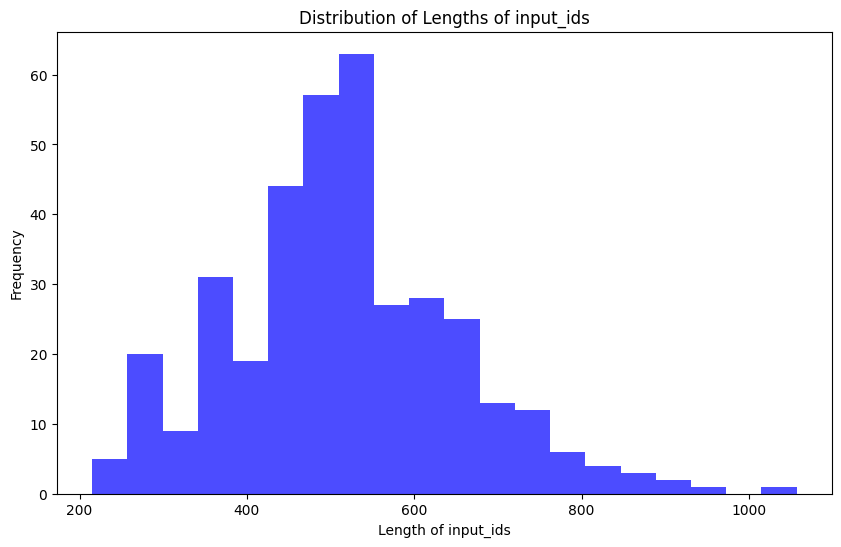

In [9]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    """
    Plot the distribution of sample lengths.

    Args:
        tokenized_train_dataset (list): Tokenized training dataset.
        tokenized_val_dataset (list): Tokenized validation dataset.
    """
    # Combine lengths of training and validation datasets
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

# Call the function with tokenized datasets
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

# Reformatting Prompt and Tokenizing with Truncation

370


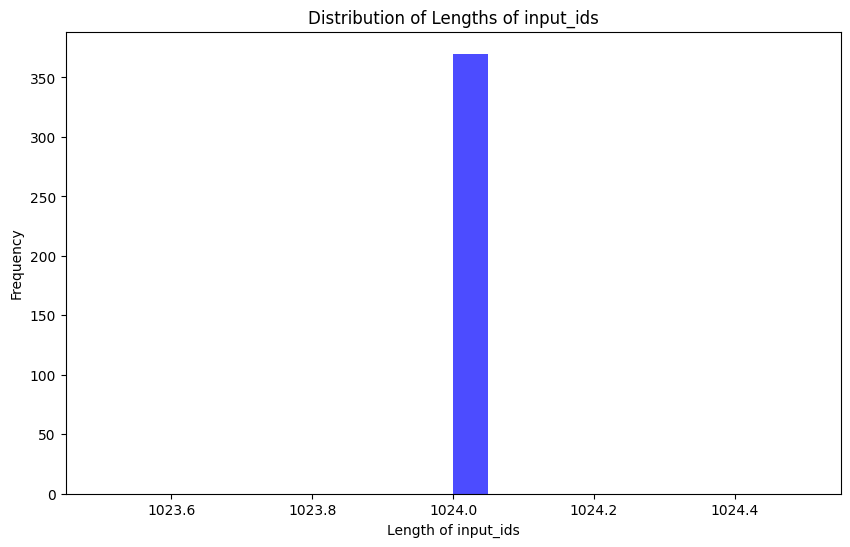

In [10]:
max_length = 1024 # This was an appropriate max length for my dataset

# Reformat prompt and tokenize each message with truncation
def generate_and_tokenize_prompt_with_trunc(prompt):
    """
    Reformat prompt and tokenize each message with truncation.

    Args:
        prompt (list): A list containing dictionaries for question, context, and answer.

    Returns:
        dict: Tokenized prompt with truncation and padding.
    """
    # Tokenize prompt with truncation and padding
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    
    # Set labels to input_ids for CausalLM
    result["labels"] = result["input_ids"].copy()
    return result

# Tokenize training dataset with truncation and padding
tokenized_train_dataset = list(map(lambda record: generate_and_tokenize_prompt_with_trunc(record['messages']), train_dataset))

# Tokenize validation dataset with truncation and padding
tokenized_val_dataset = list(map(lambda record: generate_and_tokenize_prompt_with_trunc(record['messages']), eval_dataset))

# Plot the distribution of lengths
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

# Checking Base Model Performance - Getting the Complete Prompt

In [11]:
prompt = formatting_func(eval_dataset[0]['messages'])

# Find the index of "### Answer:"
index_answer = prompt.find("### Answer:")

# Extract the prompt for text generation up to "### Answer:"
eval_prompt = prompt[:index_answer + len("### Answer:")].strip()

# Print the complete message and the prompt for text generation
print(f"""
Complete message:

{prompt}

Prompt for text-generation:

{eval_prompt}
""")


Complete message:

### Question: What is the correlation between transaction scores and customer city, as well as product category during peak hours, specifically from 8 AM to 10 AM?

### Context: 
You are a Python function generator. Users will ask you questions in English, 
and you will produce a Python function as answer to the question based on the provided CONTEXT.

CONTEXT:
Pandas DataFrame df containing transaction data with columns order_id, user_id, item_id, timestamp, score.
order_id takes string datatype and identifies the order.
user_id takes string datatype and identifies the customer.
item_id takes string datatype that identifies the product.
timestamp takes timestamp datatype and represents the datetimestamp of transaction.
score takes float datatype and represents the score of the transaction.
Note that a customer can make multiple transactions for a product but the customer product pair will be just one entry for each order.
Pandas DataFrame customer_dfcontaining cust

# Initializing Evaluation Tokenizer

In [12]:
# Initialize evaluation tokenizer without padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True, # Add beginning-of-sequence token
)

# Tokenize the prompt and convert to PyTorch tensors
model_input = eval_tokenizer(
    eval_prompt, 
    return_tensors="pt" # Return PyTorch tensors
).to("cuda") # Move tensors to GPU if available

# Set the model to evaluation mode
model.eval()

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
   

# Generating Text with Base Model

In [13]:
# Disable gradient calculation during inference
with torch.no_grad():
    # Generate text based on the model input
    generated_tokens = model.generate(
        **model_input,  # Pass model input
        max_new_tokens=1024,  # Maximum number of new tokens to generate
        repetition_penalty=1.15,  # Repetition penalty to avoid repetition
        pad_token_id=eval_tokenizer.eos_token_id  # Set pad token ID
    )[0]  # Get the first generated sequence

    # Decode the generated tokens into text, skipping special tokens
    generated_text = eval_tokenizer.decode(
        generated_tokens,  # Generated tokens
        skip_special_tokens=True  # Skip special tokens like padding and eos
    )

    # Print the generated text
    print(generated_text)

### Question: What is the correlation between transaction scores and customer city, as well as product category during peak hours, specifically from 8 AM to 10 AM?

### Context: 
You are a Python function generator. Users will ask you questions in English, 
and you will produce a Python function as answer to the question based on the provided CONTEXT.

CONTEXT:
Pandas DataFrame df containing transaction data with columns order_id, user_id, item_id, timestamp, score.
order_id takes string datatype and identifies the order.
user_id takes string datatype and identifies the customer.
item_id takes string datatype that identifies the product.
timestamp takes timestamp datatype and represents the datetimestamp of transaction.
score takes float datatype and represents the score of the transaction.
Note that a customer can make multiple transactions for a product but the customer product pair will be just one entry for each order.
Pandas DataFrame customer_dfcontaining customer data with colum

# Setting up LoRA - "Low Rank Adaptation"

In [14]:
# Import necessary library
from peft import prepare_model_for_kbit_training

# Enable gradient checkpointing
model.gradient_checkpointing_enable()

# Prepare the model for k-bit training with LoRA
model = prepare_model_for_kbit_training(model)

def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    
    # Iterate over model parameters
    for _, param in model.named_parameters():
        all_param += param.numel()
        
        # Check if the parameter requires gradient
        if param.requires_grad:
            trainable_params += param.numel()
    
    # Print the number of trainable parameters and their percentage
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

# Call the function to print trainable parameters
print_trainable_parameters(model)

# Print the model
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
   

# Defining LoRA Configuration

In [15]:
# Import necessary libraries
from peft import LoraConfig, get_peft_model

# Define LoRA configuration
config = LoraConfig(
    r=64,                  # Rank parameter
    lora_alpha=16,         # Alpha parameter
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],                     # Target modules for low-rank adaptation
    bias="none",           # Disable bias
    lora_dropout=0.05,     # Conventional Dropout rate for LoRA
    task_type="CAUSAL_LM", # Task type
)

# Update the model with LoRA configuration
model = get_peft_model(model, config)

# Print the number of trainable parameters
print_trainable_parameters(model)

# Print the model
print(model)

trainable params: 170082304 || all params: 3922153472 || trainable%: 4.336452033664837


# Enable Parallelisation if Multiple GPUs Available

In [17]:
if torch.cuda.device_count() > 1:
    
    # Enable parallelization
    model.is_parallelizable = True
    model.model_parallel = True

# Use Accelerator

In [18]:
model = accelerator.prepare_model(model)

# Training model

In [19]:
##### WARNING #####
# Ignore the below warning probably generated by the data_collator
# You're using a LlamaTokenizerFast tokenizer. 
# Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
#
# Ignore the below warning based on the Lora config setup.
# UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
#  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
##### ####### #####

# Import necessary libraries
import transformers
from datetime import datetime
import shutil
import os

# Define iteration string, project name, base model name, and run name
iter_str = "01"
project = "finetune"
base_model_name = "mistral"
run_name = iter_str + "-" + project + "-" + base_model_name
output_dir = "../models/" + run_name

# Remove output directory if it exists
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)

# Initialize the Trainer
trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        gradient_checkpointing_kwargs={"use_reentrant":True},
        max_steps=500,
        learning_rate=2.5e-5,                                              # Want a small lr for finetuning
        bf16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,                                                  # When to start reporting loss
        logging_dir="./logs",                                              # Directory for storing logs
        save_strategy="steps",                                             # Save the model checkpoint every logging step
        save_steps=25,                                                     # Save checkpoints every 25 steps
        evaluation_strategy="steps",                                       # Evaluate the model every logging step
        eval_steps=25,                                                     # Evaluate and save checkpoints every 25 steps
        do_eval=True,                                                      # Perform evaluation at the end of training
        report_to="wandb",                                                 # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}" # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(
        tokenizer, 
        mlm=False
    ),
)

# Disable cache
model.config.use_cache = False                                             # silence the warnings. Please re-enable for inference!

# Start model training
trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
25,0.832600,0.366647
50,0.260800,0.214074
75,0.202300,0.193150
100,0.179300,0.179275
125,0.177500,0.171954
150,0.179300,0.167746
175,0.150200,0.163398
200,0.140300,0.160591
225,0.121200,0.160815
250,0.141100,0.158014


/home/jovyan/LLM_CRM_PERSO/.venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:139: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/home/jovyan/LLM_CRM_PERSO/.venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:139: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/home/jovyan/LLM_CRM_PERSO/.venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:139: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/home/jovyan/LLM_CRM_PERSO/.venv/lib/python3.10/site-packages/peft/utils/save_and_loa

TrainOutput(global_step=500, training_loss=0.17971011972427367, metrics={'train_runtime': 868.944, 'train_samples_per_second': 1.151, 'train_steps_per_second': 0.575, 'total_flos': 4.45986826616832e+16, 'train_loss': 0.17971011972427367, 'epoch': 3.03})

# Loading Base Model for Inference

In [20]:
# Import necessary libraries
import torch
from transformers import (
    AutoTokenizer, 
    AutoModelForCausalLM, 
    BitsAndBytesConfig
)

# Define Mistral's pretrained model ID
base_model_id = "mistralai/Mistral-7B-v0.1"

# Define BitsAndBytesConfig for Mistral's model
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load Mistral's pretrained model for causal language modeling
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id, 
    quantization_config=bnb_config, 
    device_map="auto"
)

# Load Mistral's tokenizer
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id, 
    add_bos_token=True,     # Add beginning-of-sequence token
    trust_remote_code=True  # Trust remote code for tokenization
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# Loading Fine-Tuned Model from Checkpoint

In [21]:
from peft import PeftModel

# Load the weights from the checkpoint directory
ft_model = PeftModel.from_pretrained(base_model, "../models/01-finetune-mistral/checkpoint-150")

# Loading Datasets and Setting Up Evaluation

In [22]:
from datasets import load_dataset

# Load training, validation, and test datasets
train_dataset = load_dataset('json', data_files='../data/train_CRM_data.json', split='train')
eval_dataset = load_dataset('json', data_files='../data/val_CRM_data.json', split='train')
test_dataset = load_dataset('json', data_files='../data/test_CRM_data.json', split='train')

# Formatting prompts
def formatting_func(message):
    """
    Formats a message containing question, context, and answer into a structured text format.

    Args:
        message (list): A list containing dictionaries for question, context, and answer.

    Returns:
        str: Formatted text containing the question, context, and answer.
    """
    
    # Extracting question, context, and answer from the message
    question = message[1]['content']
    context = message[0]['content']
    answer = message[2]['content']

    # Formatting the extracted information into text format
    text_format = f"""
### Question: {question}

### Context: {context}
### Answer: 
{answer}
    """

    return text_format.strip()

# check base model performance
prompt = formatting_func(eval_dataset[0]['messages'])

# Find the index of "### Answer:"
index_answer = prompt.find("### Answer:")

# Extract the string up to "### Answer:"
eval_prompt = prompt[:index_answer + len("### Answer:")].strip()

# Init an eval tokenizer that doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

# Tokenize the evaluation prompt and prepare model input for inference
model_input = eval_tokenizer(
    eval_prompt, 
    return_tensors="pt"
).to("cuda")  # Move tensors to GPU if available

# Set the model to evaluation mode
ft_model.eval()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): Lin

# Generating Text with Fine-Tuned Model

In [23]:
# Disable gradient calculation during inference
with torch.no_grad():
    # Generate text based on the model input
    generated_tokens = ft_model.generate(
        **model_input,  # Pass model input
        max_new_tokens=1024,  # Maximum number of new tokens to generate
        repetition_penalty=1.15,  # Repetition penalty to avoid repetition
        pad_token_id=eval_tokenizer.eos_token_id  # Set pad token ID
    )[0]  # Get the first generated sequence

    # Decode the generated tokens into text, skipping special tokens
    generated_text = eval_tokenizer.decode(
        generated_tokens,  # Generated tokens
        skip_special_tokens=True  # Skip special tokens like padding and eos
    )

    # Print the generated text
    print(generated_text)

### Question: What is the correlation between transaction scores and customer city, as well as product category during peak hours, specifically from 8 AM to 10 AM?

### Context: 
You are a Python function generator. Users will ask you questions in English, 
and you will produce a Python function as answer to the question based on the provided CONTEXT.

CONTEXT:
Pandas DataFrame df containing transaction data with columns order_id, user_id, item_id, timestamp, score.
order_id takes string datatype and identifies the order.
user_id takes string datatype and identifies the customer.
item_id takes string datatype that identifies the product.
timestamp takes timestamp datatype and represents the datetimestamp of transaction.
score takes float datatype and represents the score of the transaction.
Note that a customer can make multiple transactions for a product but the customer product pair will be just one entry for each order.
Pandas DataFrame customer_dfcontaining customer data with colum

# Comparing Generated and Original Solutions

In [24]:
print(prompt[index_answer:].strip()) ### Original solution - Ground truth

### Answer: 
def correlate_score_with_category_and_peak_hours(df, customer_df, product_df, peak_hours=[8, 9, 10]):\n    df = pd.merge(df, customer_df, on='user_id', how='left')\n    df = pd.merge(df, product_df, on='item_id', how='left')\n    peak_hour_transactions = df[df['timestamp'].dt.hour.isin(peak_hours)]\n    city_scores = peak_hour_transactions.groupby('customer_city')['score'].mean()\n    category_scores = peak_hour_transactions.groupby('product_category')['score'].mean()\n    city_correlation = peak_hour_transactions.groupby('customer_city')['score'].corr(city_scores)\n    category_correlation = peak_hour_transactions.groupby('product_category')['score'].corr(category_scores)\n    return city_correlation, category_correlation\n


In [25]:
print("Generated Solution:\n")
print("""def correlate_transaction_scores(df, customer_df, product_df):\n    merged_df = pd.merge(df, customer_df, on='user_id')\n    merged_df = pd.merge(merged_df, product_df, on='item_id')\n    merged_df['hour'] = merged_df['timestamp'].dt.hour\n    hourly_transactions = merged_df[merged_df['hour'] >= 8]\n    hourly_transactions['peak_hours'] = (hourly_transactions['hour'] >= 8) & (hourly_transactions['hour'] < 10)\n    if 'peak_hours' not in hourly_transactions.columns:\n        hourly_transactions['peak_hours'] = False\n    return hourly_transactions.groupby(['customer_city', 'product_category', 'peak_hours'])['score'].mean().unstack()\n
correlate_transaction_scores(df, customer_df, product_df).plot(kind='bar', stacked=True, figsize=(12, 6))\nplt.title('Correlation Between Transaction Scores and Customer City/Product Category During Peak Hours')\nplt.xlabel('Customer City/Product Category')\nplt.ylabel('Average Score')\nplt.legend(loc='best')\nplt.show()""")

Generated Solution:

def correlate_transaction_scores(df, customer_df, product_df):
    merged_df = pd.merge(df, customer_df, on='user_id')
    merged_df = pd.merge(merged_df, product_df, on='item_id')
    merged_df['hour'] = merged_df['timestamp'].dt.hour
    hourly_transactions = merged_df[merged_df['hour'] >= 8]
    hourly_transactions['peak_hours'] = (hourly_transactions['hour'] >= 8) & (hourly_transactions['hour'] < 10)
    if 'peak_hours' not in hourly_transactions.columns:
        hourly_transactions['peak_hours'] = False
    return hourly_transactions.groupby(['customer_city', 'product_category', 'peak_hours'])['score'].mean().unstack()

correlate_transaction_scores(df, customer_df, product_df).plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Correlation Between Transaction Scores and Customer City/Product Category During Peak Hours')
plt.xlabel('Customer City/Product Category')
plt.ylabel('Average Score')
plt.legend(loc='best')
plt.show()


In [26]:
print("Original Solution:\n")
print("""def correlate_score_with_category_and_peak_hours(df, customer_df, product_df, peak_hours=[8, 9, 10]):\n    df = pd.merge(df, customer_df, on='user_id', how='left')\n    df = pd.merge(df, product_df, on='item_id', how='left')\n    peak_hour_transactions = df[df['timestamp'].dt.hour.isin(peak_hours)]\n    city_scores = peak_hour_transactions.groupby('customer_city')['score'].mean()\n    category_scores = peak_hour_transactions.groupby('product_category')['score'].mean()\n    city_correlation = peak_hour_transactions.groupby('customer_city')['score'].corr(city_scores)\n    category_correlation = peak_hour_transactions.groupby('product_category')['score'].corr(category_scores)\n    return city_correlation, category_correlation\n""")

Original Solution:

def correlate_score_with_category_and_peak_hours(df, customer_df, product_df, peak_hours=[8, 9, 10]):
    df = pd.merge(df, customer_df, on='user_id', how='left')
    df = pd.merge(df, product_df, on='item_id', how='left')
    peak_hour_transactions = df[df['timestamp'].dt.hour.isin(peak_hours)]
    city_scores = peak_hour_transactions.groupby('customer_city')['score'].mean()
    category_scores = peak_hour_transactions.groupby('product_category')['score'].mean()
    city_correlation = peak_hour_transactions.groupby('customer_city')['score'].corr(city_scores)
    category_correlation = peak_hour_transactions.groupby('product_category')['score'].corr(category_scores)
    return city_correlation, category_correlation



# Generating Sample Data and Copying

In [27]:
# Import Libraries
import pandas as pd
import random
from faker import Faker

# Initialize Faker to generate fake data
fake = Faker()

# List of famous city names as customer city
european_cities = [
    'London', 'Paris'
]

# Generate sample data for transactions / orders
orders_data = []
for i in range(1, 16):
    order_id = f'order{i}'
    user_id = f'user{random.randint(1, 5)}'
    item_id = f'item{random.randint(1, 3)}'
    timestamp = fake.date_time_between(start_date='-5d', end_date='now')
    score = round(random.uniform(0.5, 1.0), 2)
    orders_data.append({'order_id': order_id, 'user_id': user_id, 'item_id': item_id, 'timestamp': timestamp, 'score': score})
orig_df = pd.DataFrame(orders_data)

# Generate sample data for customers / users
customers_data = []
for i in range(1, 6):
    user_id = f'user{i}'
    customer_city = random.choice(european_cities)
    customers_data.append({'user_id': user_id, 'customer_city': customer_city})
orig_customer_df = pd.DataFrame(customers_data).drop_duplicates(subset=['user_id'])

# Generate sample data for products
products_data = []
for i in range(1, 6):
    item_id = f'item{i}'
    product_category = fake.word()
    products_data.append({'item_id': item_id, 'product_category': product_category})
orig_product_df = pd.DataFrame(products_data).drop_duplicates(subset=['item_id'])

def data_copy(orig_df, orig_customer_df, orig_product_df):
    """
    Copy the original dataframes to new ones.

    Args:
    - orig_df (pandas DataFrame): The original dataframe to be copied.
    - orig_customer_df (pandas DataFrame): The original customer dataframe to be copied.
    - orig_product_df (pandas DataFrame): The original product dataframe to be copied.

    Returns:
    - df (pandas DataFrame): A deep copy of the original dataframe.
    - customer_df (pandas DataFrame): A deep copy of the original customer dataframe.
    - product_df (pandas DataFrame): A deep copy of the original product dataframe.
    """
    df = orig_df.copy(deep=True)
    customer_df = orig_customer_df.copy(deep=True)
    product_df = orig_product_df.copy(deep=True)
    return df, customer_df, product_df

# Call the function to create copies of the original dataframes
df, customer_df, product_df = data_copy(orig_df, orig_customer_df, orig_product_df)

# Displaying sample data
print("Orders Data:")
print(df)
print("\nCustomer Data:")
print(customer_df)
print("\nProduct Data:")
print(product_df)

Orders Data:
   order_id user_id item_id                  timestamp  score
0    order1   user1   item1 2024-04-17 09:43:18.786843   0.87
1    order2   user2   item1 2024-04-18 13:15:43.832856   0.57
2    order3   user1   item3 2024-04-15 23:47:12.415959   0.87
3    order4   user5   item1 2024-04-18 11:42:01.433933   0.80
4    order5   user1   item1 2024-04-17 04:00:40.644762   0.55
5    order6   user2   item3 2024-04-18 10:13:49.744231   0.80
6    order7   user5   item1 2024-04-20 21:17:04.848783   0.86
7    order8   user5   item2 2024-04-20 15:33:03.570342   0.61
8    order9   user5   item2 2024-04-17 00:45:04.036906   0.90
9   order10   user1   item1 2024-04-17 15:15:42.389925   0.85
10  order11   user3   item2 2024-04-17 03:33:56.200595   0.58
11  order12   user3   item1 2024-04-18 17:44:14.151413   0.55
12  order13   user1   item2 2024-04-17 11:32:48.860542   0.92
13  order14   user5   item2 2024-04-19 07:57:58.488862   0.90
14  order15   user4   item3 2024-04-17 00:43:29.541387   

# Evaluate Original vs Generated Text Performance by Executing the Respective Functions with Data

/tmp/ipykernel_3576/3621278173.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hourly_transactions['peak_hours'] = (hourly_transactions['hour'] >= 8) & (hourly_transactions['hour'] < 10)


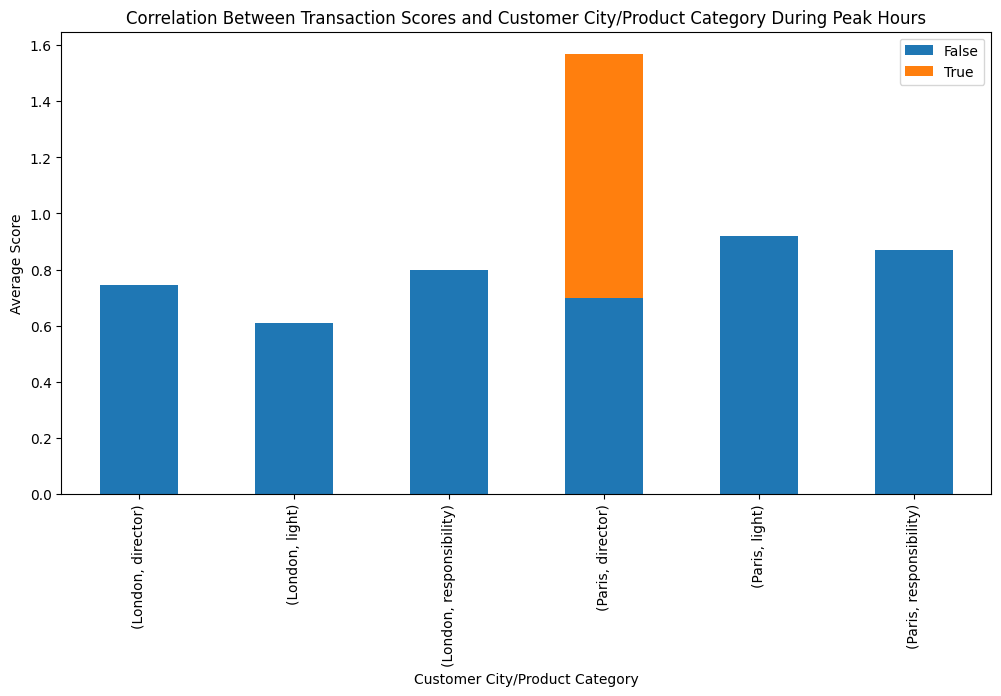

/tmp/ipykernel_3576/3621278173.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hourly_transactions['peak_hours'] = (hourly_transactions['hour'] >= 8) & (hourly_transactions['hour'] < 10)



Original Solution:

(customer_city
London   NaN
Paris    NaN
Name: score, dtype: float64, product_category
director         NaN
responsibility   NaN
Name: score, dtype: float64)

Generated Solution:

peak_hours                         False  True 
customer_city product_category                 
London        director          0.743333    NaN
              light             0.610000    NaN
              responsibility    0.800000    NaN
Paris         director          0.700000   0.87
              light             0.920000    NaN
              responsibility    0.870000    NaN



In [28]:
# Import necessary libraries
import pandas as pd
import numpy as np
from numpy.linalg import LinAlgError
from datetime import datetime, timedelta
from collections import defaultdict, Counter
from itertools import combinations
from scipy.sparse import csr_matrix
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from surprise import Reader, Dataset
from surprise.prediction_algorithms import SVD
from matplotlib import pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
import pandas as pd

# Suppress warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Original Function to correlate score with category and peak hours
def correlate_score_with_category_and_peak_hours(df, customer_df, product_df, peak_hours=[8, 9, 10]):
    df = pd.merge(df, customer_df, on='user_id', how='left')
    df = pd.merge(df, product_df, on='item_id', how='left')
    peak_hour_transactions = df[df['timestamp'].dt.hour.isin(peak_hours)]
    city_scores = peak_hour_transactions.groupby('customer_city')['score'].mean()
    category_scores = peak_hour_transactions.groupby('product_category')['score'].mean()
    city_correlation = peak_hour_transactions.groupby('customer_city')['score'].corr(city_scores)
    category_correlation = peak_hour_transactions.groupby('product_category')['score'].corr(category_scores)
    return city_correlation, category_correlation

# Original correlation results
original_res = correlate_score_with_category_and_peak_hours(df, customer_df, product_df, peak_hours=[8, 9, 10])

# Generated Function to correlate transaction scores
def correlate_transaction_scores(df, customer_df, product_df):
    merged_df = pd.merge(df, customer_df, on='user_id')
    merged_df = pd.merge(merged_df, product_df, on='item_id')
    merged_df['hour'] = merged_df['timestamp'].dt.hour
    hourly_transactions = merged_df[merged_df['hour'] >= 8]
    hourly_transactions['peak_hours'] = (hourly_transactions['hour'] >= 8) & (hourly_transactions['hour'] < 10)
    if 'peak_hours' not in hourly_transactions.columns:
        hourly_transactions['peak_hours'] = False
    return hourly_transactions.groupby(['customer_city', 'product_category', 'peak_hours'])['score'].mean().unstack()

correlate_transaction_scores(df, customer_df, product_df).plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Correlation Between Transaction Scores and Customer City/Product Category During Peak Hours')
plt.xlabel('Customer City/Product Category')
plt.ylabel('Average Score')
plt.legend(loc='best')
plt.show()

# Generated correlation results
generated_res = correlate_transaction_scores(df, customer_df, product_df)

# Print original and generated results for comparison
print(f"""
Original Solution:

{original_res}

Generated Solution:

{generated_res}
""")

The contrast between the original and fine-tuned versions of the model underscores a significant evolution in both approach and efficacy.

Initially, the base model exhibits a comprehensive yet somewhat verbose function. It adeptly handles data loading and multiple transformations, demonstrating a robust grasp of Python programming. However, it lacks contextual understanding and fails to directly address the core question. Instead, it presents various solutions, none of which sufficiently meet the criteria of functionality and relevance to the user's query.

In contrast, post fine-tuning, the function becomes more succinct and purposeful. It squarely tackles the question at hand and leverages Pandas' functionalities for efficient data manipulation and correlation computation. Consequently, the solution becomes streamlined and more effective. Moreover, it includes a step-by-step explanation and an illustrative example, enhancing its usability and clarity. This feature stands out to provide the explanability feature for building and designing responsible AI.

In summary, while both versions exhibit proficiency in Python programming and data analysis, the fine-tuned function shines through its clarity, efficiency, and user-centric design, rendering it a more potent tool.